# Experimentación

En este notebook corremos los experimentos descritos en el informe

In [17]:
import subprocess

ALGORITHMS = [
    #"BT-F",
    "BT-O",
    #"BT",
    #"DP",
    #"FB",
]

def run(algorithm: str, instance_path: str) -> (int, float):
    """Corre el programa para la instancia dada y devuelve (resultado, tiempo de ejecucion)."""
    result = subprocess.run(
        f"../build/npm {algorithm} < {instance_path}",
        shell=True, capture_output=True, text=True, check=True,
    )

    return int(result.stdout), float(result.stderr)

In [18]:
from typing import List

def get_instances(dataset: str) -> List[str]:
    """Para cada dataset devuelve la lista de instancias correspondientes con el path completo"""
    instances = os.listdir(f"instancias/{dataset}")
    return list(filter(
        lambda i: i.endswith(".in"),
        map(lambda i: f"instancias/{dataset}/"+i, instances),
    ))


In [19]:
def run_instance(rows: list, dataset: str):
    """
    Corre una instancia para todos los algoritmos, llenando por referencia
    la lista de rows. Lanza una excepcion si para alguna instancia los
    resultados de todos los algoritmos no coinciden.
    """
    for instance in tqdm(get_instances(dataset), "instancias"):
        results = []
        for alg in ALGORITHMS:
            res, t = run(alg, instance)
            rows.append({
                "dataset": dataset,
                "algorithm": alg,
                "time_ms": t,
                "instance": instance,
            })

            results.append(res)

        if not np.alltrue([results[0] == res for res in results]):
            raise f"Ojo que con la instancia {instance} no dieron todos iguales"

## Experimento 1 - Control

In [28]:
import os
import numpy as np
import pandas as pd

from tqdm import tqdm

rows = []

datasets = [
    #"control", # Experimento 1 - Control
    #"grupos",   # Experimento 2 - Solapamiento por grupos
    #"identicos", # Experimento 3 - Todas instancias identicas
    "one-to-rule" # Experimento 4 - One tu rul dem ol
]

REPETICIONES = 10

for d in datasets:
    for _ in range(REPETICIONES):
        run_instance(rows, d)

df_results = pd.DataFrame(rows, columns=["dataset", "algorithm", "time_ms", "instance"])
print("Finished!")

instancias: 100%|██████████| 20/20 [00:01<00:00, 17.28it/s]

Finished!


,dataset,algorithm,time_ms,instance,pos
0,one-to-rule,BT-O,51.2932,instancias/one-to-rule/2.in,
1,one-to-rule,BT-O,47.3113,instancias/one-to-rule/pos_16.in,16
2,one-to-rule,BT-O,47.3158,instancias/one-to-rule/3.in,
3,one-to-rule,BT-O,43.5779,instancias/one-to-rule/14.in,n
4,one-to-rule,BT-O,45.4797,instancias/one-to-rule/pos_13.in,13


<AxesSubplot:xlabel='algorithm', ylabel='time_ms'>

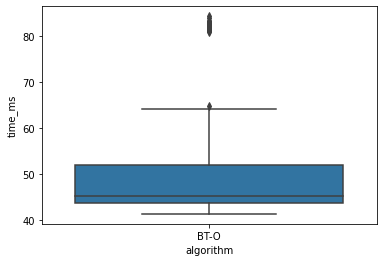

In [23]:
import seaborn as sns

sns.boxplot(data=df_results, y="time_ms", x="algorithm")

In [29]:
# instancias/grupos/6-grupos_1.in
#df_results["grupo"] = df_results["instance"].map(lambda r: r.split("/")[2][0])
# instancias/one-to-rule/pos_i.in
df_results["pos"] = df_results["instance"].map(lambda r: int(r.split("/")[2][4:].split('.')[0]))

In [30]:
df_results

,dataset,algorithm,time_ms,instance,pos
0,one-to-rule,BT-O,47.5266,instancias/one-to-rule/pos_16.in,16
1,one-to-rule,BT-O,44.6092,instancias/one-to-rule/pos_13.in,13
2,one-to-rule,BT-O,54.7605,instancias/one-to-rule/pos_17.in,17
3,one-to-rule,BT-O,43.1216,instancias/one-to-rule/pos_10.in,10
4,one-to-rule,BT-O,43.6970,instancias/one-to-rule/pos_11.in,11
...,...,...,...,...,...
195,one-to-rule,BT-O,53.7698,instancias/one-to-rule/pos_1.in,1
196,one-to-rule,BT-O,46.6934,instancias/one-to-rule/pos_3.in,3
197,one-to-rule,BT-O,53.4060,instancias/one-to-rule/pos_0.in,0
198,one-to-rule,BT-O,83.1587,instancias/one-to-rule/pos_19.in,19


<AxesSubplot:xlabel='grupo', ylabel='time_ms'>

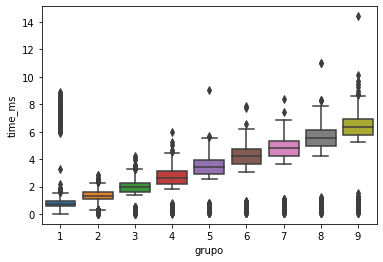

In [59]:
sns.boxplot(data=df_results.sort_values("grupo"), x="grupo", y="time_ms")

<AxesSubplot:xlabel='pos', ylabel='time_ms'>

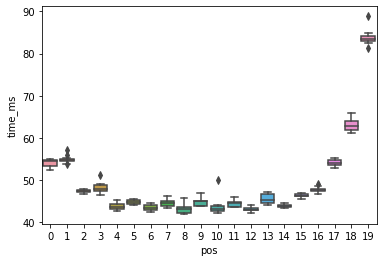

In [31]:
sns.boxplot(data=df_results.sort_values("pos"), x="pos", y="time_ms")
# tiene sentido que el ultimo tarde mas porque recorre primero todo, y despues chequea la opt, que es lo mismo que NADA